In [1]:
# 📦 Imports y Configuración
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import make_moons, make_classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn

# Boosting Libraries
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    print("⚠️ XGBoost no instalado. Ejecuta: pip install xgboost")
    XGB_AVAILABLE = False

try:
    import lightgbm as lgb
    LGBM_AVAILABLE = True
except ImportError:
    print("⚠️ LightGBM no instalado. Ejecuta: pip install lightgbm")
    LGBM_AVAILABLE = False

# Configuración Visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

RANDOM_STATE = 42


---

## 2. Del Bagging al Boosting

### Comparación Visual

| Aspecto | Random Forest (Bagging) | Gradient Boosting |
|---------|-------------------------|-------------------|
| **Entrenamiento** | Paralelo | Secuencial |
| **Cada Árbol Aprende** | Del dataset completo | De los errores anteriores |
| **Combinación** | Votación/Promedio | Suma ponderada |
| **Reduce** | Varianza | Sesgo |
| **Riesgo** | Bajo | Overfitting si no controlas |

```
Random Forest:    🌳 + 🌳 + 🌳 + ... → PROMEDIO
                  (cada uno independiente)

Gradient Boosting: 🌱 → 🌱 → 🌱 → ... → SUMA
                   (cada uno corrige al anterior)
```

---

## 3. La Intuición: Aprender del Error

### El Algoritmo (Simplificado)

1. **Inicializar:** Predicción base (ej: promedio del target)
2. **Para cada iteración t:**
   - Calcular residuales: $r_i = y_i - \hat{y}_i$
   - Entrenar árbol pequeño para predecir residuales
   - Actualizar: $\hat{y} = \hat{y} + \eta \cdot h_t(x)$
3. **Predicción final:** Suma de todos los árboles

### 🔑 La Clave: Learning Rate (η)

$$\hat{y}^{(t)} = \hat{y}^{(t-1)} + \eta \cdot h_t(x)$$

- **η alto (0.3):** Aprende rápido, pero puede saltar el óptimo
- **η bajo (0.01):** Aprende lento, pero más preciso

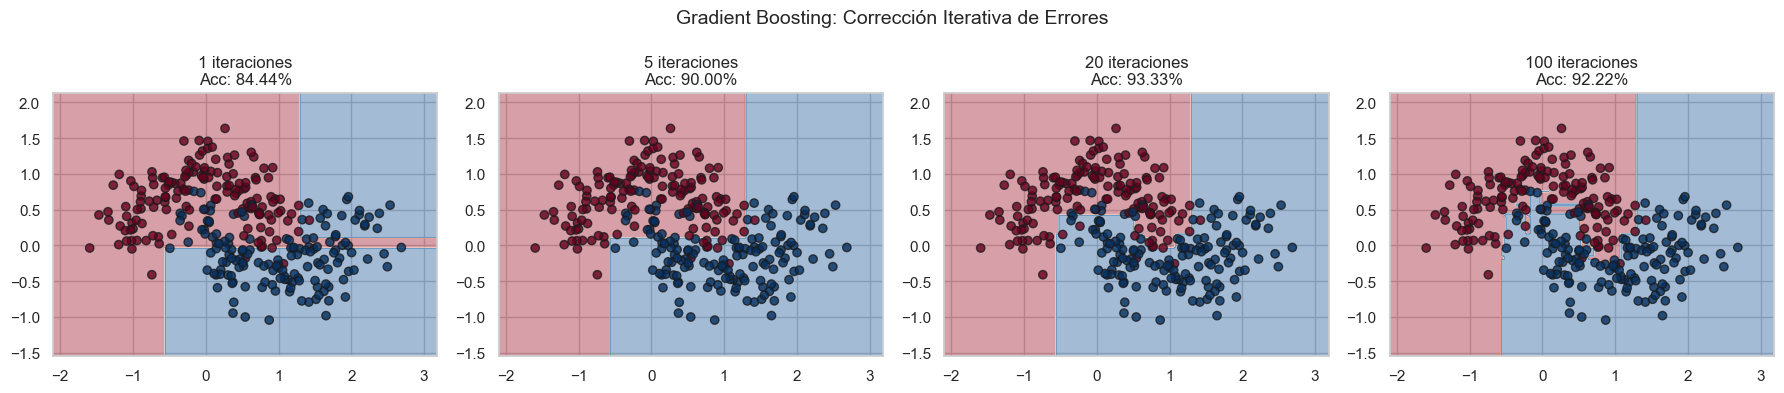

In [2]:
# Visualización: Cómo el Boosting corrige errores iterativamente
from sklearn.ensemble import GradientBoostingClassifier

X, y = make_moons(n_samples=300, noise=0.25, random_state=RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE)

# Función para visualizar frontera


def plot_decision_boundary(model, X, y, ax, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='k', alpha=0.8)
    ax.set_title(title)


# Entrenar con diferentes números de iteraciones
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
iterations = [1, 5, 20, 100]

for ax, n_iter in zip(axes, iterations):
    gb = GradientBoostingClassifier(n_estimators=n_iter, learning_rate=0.1,
                                    max_depth=3, random_state=RANDOM_STATE)
    gb.fit(X_train, y_train)
    plot_decision_boundary(gb, X, y, ax,
                           f'{n_iter} iteraciones\nAcc: {gb.score(X_test, y_test):.2%}')

plt.suptitle('Gradient Boosting: Corrección Iterativa de Errores', fontsize=14)
plt.tight_layout()
plt.show()


---

## 4. XGBoost en Acción

### ¿Por Qué XGBoost Domina Kaggle?

| Característica | Beneficio |
|----------------|----------|
| **Regularización L1/L2** | Controla overfitting |
| **Manejo de Missing Values** | No requiere imputación |
| **Tree Pruning** | Poda inteligente (no greedy) |
| **Paralelización** | Rápido a pesar de ser secuencial |

In [3]:
if XGB_AVAILABLE:
    # Entrenar XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)

    print(f"📊 XGBoost Accuracy: {xgb_model.score(X_test, y_test):.2%}")
else:
    print("⚠️ XGBoost no disponible. Usando GradientBoostingClassifier de sklearn.")
    xgb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                           max_depth=4, random_state=RANDOM_STATE)
    xgb_model.fit(X_train, y_train)
    print(
        f"📊 GradientBoosting Accuracy: {xgb_model.score(X_test, y_test):.2%}")


📊 XGBoost Accuracy: 94.44%


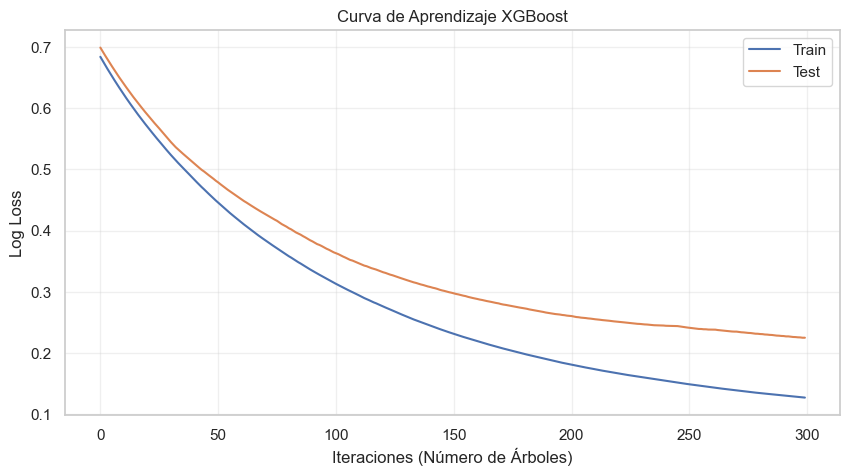

⚠️ Si Test sube mientras Train baja → OVERFITTING
💡 Solución: Early Stopping o reducir n_estimators


In [20]:
# Curva de aprendizaje: Training vs Validation
if XGB_AVAILABLE:
    eval_set = [(X_train, y_train), (X_test, y_test)]
    xgb_model_track = xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.01,
        max_depth=5,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model_track.fit(X_train, y_train, eval_set=eval_set, verbose=False)

    results = xgb_model_track.evals_result()

    plt.figure(figsize=(10, 5))
    plt.plot(results['validation_0']['logloss'], label='Train')
    plt.plot(results['validation_1']['logloss'], label='Test')
    plt.xlabel('Iteraciones (Número de Árboles)')
    plt.ylabel('Log Loss')
    plt.title('Curva de Aprendizaje XGBoost')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print("⚠️ Si Test sube mientras Train baja → OVERFITTING")
    print("💡 Solución: Early Stopping o reducir n_estimators")


---

## 5. LightGBM: Velocidad y Escala

### ¿Por Qué LightGBM es Más Rápido?

| Técnica | Descripción |
|---------|-------------|
| **Leaf-wise Growth** | Crece el nodo que más reduce el error (vs level-wise) |
| **Histogram-based** | Agrupa valores continuos en bins |
| **GOSS** | Muestrea inteligentemente (mantiene gradientes grandes) |

```
XGBoost (Level-wise):    [___________]
                         [_____][_____]
                         [__][__][__][__]

LightGBM (Leaf-wise):    [___________]
                         [_____][_____]
                         [__]        [_____]
                                     [__][__]
```

In [5]:
if LGBM_AVAILABLE:
    # Entrenar LightGBM
    lgbm_model = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        num_leaves=15,  # Parámetro clave en LightGBM
        random_state=RANDOM_STATE,
        verbose=-1
    )
    lgbm_model.fit(X_train, y_train)

    print(f"📊 LightGBM Accuracy: {lgbm_model.score(X_test, y_test):.2%}")
else:
    print("⚠️ LightGBM no disponible.")


📊 LightGBM Accuracy: 93.33%


In [19]:
# Comparación de tiempo de entrenamiento (con dataset más grande)
import time

X_large, y_large = make_classification(n_samples=1000000, n_features=20,
                                       n_informative=10, random_state=RANDOM_STATE)
X_tr_l, X_ts_l, y_tr_l, y_ts_l = train_test_split(X_large, y_large, test_size=0.3,
                                                  random_state=RANDOM_STATE)

times = {}

# Random Forest
start = time.time()
rf = RandomForestClassifier(
    n_estimators=100, max_depth=4, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_tr_l, y_tr_l)
times['Random Forest'] = time.time() - start

# Gradient Boosting sklearn
start = time.time()
gb = GradientBoostingClassifier(
    n_estimators=100, max_depth=4, random_state=RANDOM_STATE)
gb.fit(X_tr_l, y_tr_l)
times['GradientBoosting'] = time.time() - start

if XGB_AVAILABLE:
    start = time.time()
    xgb_l = xgb.XGBClassifier(n_estimators=100, max_depth=4, random_state=RANDOM_STATE,
                              use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
    xgb_l.fit(X_tr_l, y_tr_l)
    times['XGBoost'] = time.time() - start

if LGBM_AVAILABLE:
    start = time.time()
    lgbm_l = lgb.LGBMClassifier(
        n_estimators=100, max_depth=4, random_state=RANDOM_STATE, verbose=-1, n_jobs=-1)
    lgbm_l.fit(X_tr_l, y_tr_l)
    times['LightGBM'] = time.time() - start

# Visualizar
plt.figure(figsize=(10, 5))
plt.bar(times.keys(), times.values(), color=[
        '#4ECDC4', '#FFE66D', '#FF6B6B', '#95E1D3'])
plt.ylabel('Tiempo (segundos)')
plt.title('⏱️ Tiempo de Entrenamiento (10,000 muestras, 100 árboles)')
for i, (k, v) in enumerate(times.items()):
    plt.text(i, v + 0.05, f'{v:.2f}s', ha='center')
plt.show()


KeyboardInterrupt: 

> **💡 Pro-Tip: ¿Cuándo Usar Cada Uno?**
> - **Random Forest:** Baseline rápido, pocos hiperparámetros que tunear.
> - **XGBoost:** Competencias, máximo rendimiento con tuning.
> - **LightGBM:** Datasets grandes (>100k filas), categorical features.

---

## 6. Hiperparámetros Críticos

### Parámetros Comunes (XGBoost/LightGBM)

| Parámetro | XGBoost | LightGBM | Efecto |
|-----------|---------|----------|--------|
| Árboles | `n_estimators` | `n_estimators` | Más = más potencia (y overfitting) |
| Learning Rate | `learning_rate` | `learning_rate` | Menor = más estable |
| Profundidad | `max_depth` | `max_depth` | Control de complejidad |
| Hojas | N/A | `num_leaves` | Control principal en LGBM |
| Regularización | `reg_alpha`, `reg_lambda` | `reg_alpha`, `reg_lambda` | Penalizar complejidad |

### 🎯 Receta Práctica

```python
# Configuración inicial conservadora
params = {
    'n_estimators': 500,       # Alto, pero con early stopping
    'learning_rate': 0.05,     # Bajo para estabilidad
    'max_depth': 4,            # Árboles poco profundos
    'early_stopping_rounds': 50,  # Parar si no mejora
}
```

In [7]:
# Demo: Efecto del Learning Rate
learning_rates = [0.01, 0.05, 0.1, 0.3]
results = []

for lr in learning_rates:
    if XGB_AVAILABLE:
        model = xgb.XGBClassifier(n_estimators=200, learning_rate=lr, max_depth=4,
                                  random_state=RANDOM_STATE, use_label_encoder=False,
                                  eval_metric='logloss')
    else:
        model = GradientBoostingClassifier(n_estimators=200, learning_rate=lr,
                                           max_depth=4, random_state=RANDOM_STATE)

    scores = cross_val_score(model, X, y, cv=5)
    results.append({
        'Learning Rate': lr,
        'Mean Accuracy': np.mean(scores),
        'Std': np.std(scores)
    })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


 Learning Rate  Mean Accuracy      Std
          0.01       0.900000 0.021082
          0.05       0.916667 0.025820
          0.10       0.923333 0.024944
          0.30       0.913333 0.022111


---

## 7. Caso de Negocio: Detección de Fraude

Simularemos un dataset de detección de fraude (muy desbalanceado, como en la vida real).

In [8]:
# Simular datos de fraude (1% fraude, 99% legítimo)
np.random.seed(RANDOM_STATE)
n = 5000

# Features
monto = np.random.exponential(100, n)
hora = np.random.randint(0, 24, n)
distancia_casa = np.random.exponential(50, n)
es_fin_semana = np.random.binomial(1, 2/7, n)
transacciones_24h = np.random.poisson(3, n)

# Target (fraude más probable si: monto alto, hora nocturna, lejos de casa)
prob_fraude = 0.005 + 0.002*(monto > 200) + 0.003*(hora < 6) + \
    0.002*(distancia_casa > 100) + 0.003*(transacciones_24h > 5)
fraude = (np.random.rand(n) < prob_fraude).astype(int)

df_fraude = pd.DataFrame({
    'Monto': monto,
    'Hora': hora,
    'Distancia_Casa': distancia_casa,
    'Fin_Semana': es_fin_semana,
    'Transacciones_24h': transacciones_24h,
    'Fraude': fraude
})

print(f"📊 Distribución de clases:")
print(df_fraude['Fraude'].value_counts(normalize=True))


📊 Distribución de clases:
Fraude
0    0.9958
1    0.0042
Name: proportion, dtype: float64


In [9]:
# Preparar datos
features = ['Monto', 'Hora', 'Distancia_Casa',
            'Fin_Semana', 'Transacciones_24h']
X_fraud = df_fraude[features]
y_fraud = df_fraude['Fraude']

X_tr, X_ts, y_tr, y_ts = train_test_split(X_fraud, y_fraud, test_size=0.3,
                                          stratify=y_fraud, random_state=RANDOM_STATE)

# Entrenar modelos
rf_fraud = RandomForestClassifier(n_estimators=100, max_depth=5,
                                  class_weight='balanced', random_state=RANDOM_STATE)
rf_fraud.fit(X_tr, y_tr)

if LGBM_AVAILABLE:
    lgbm_fraud = lgb.LGBMClassifier(n_estimators=100, max_depth=5,
                                    class_weight='balanced', random_state=RANDOM_STATE, verbose=-1)
    lgbm_fraud.fit(X_tr, y_tr)

# Evaluar
print("="*50)
print("📊 EVALUACIÓN EN DETECCIÓN DE FRAUDE")
print("="*50)
print(
    f"Random Forest ROC-AUC: {roc_auc_score(y_ts, rf_fraud.predict_proba(X_ts)[:, 1]):.3f}")
if LGBM_AVAILABLE:
    print(
        f"LightGBM ROC-AUC:      {roc_auc_score(y_ts, lgbm_fraud.predict_proba(X_ts)[:, 1]):.3f}")


📊 EVALUACIÓN EN DETECCIÓN DE FRAUDE
Random Forest ROC-AUC: 0.581
LightGBM ROC-AUC:      0.579


> **⚠️ Real-World Warning: Clases Desbalanceadas**
> En fraude, el desbalance es extremo (0.1% fraude). Siempre usa:
> - `class_weight='balanced'`
> - Métricas como ROC-AUC, Precision-Recall (NO solo Accuracy)
> - Técnicas de resampling (SMOTE) si es necesario

### 🧠 Micro-Desafío: Early Stopping

**Pregunta:** Si entrenas un modelo con 1000 árboles y `learning_rate=0.01`, ¿cómo sabes cuándo parar?

**Respuesta:** Usa `early_stopping_rounds` para detener el entrenamiento cuando el error de validación no mejora.

In [10]:
# Demo: Early Stopping
if XGB_AVAILABLE:
    xgb_early = xgb.XGBClassifier(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=4,
        early_stopping_rounds=50,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='auc'
    )
    xgb_early.fit(X_tr, y_tr, eval_set=[(X_ts, y_ts)], verbose=False)

    print(
        f"🛑 Early Stopping: Entrenó {xgb_early.best_iteration} árboles (de 1000 posibles)")
    print(f"📊 Best ROC-AUC: {xgb_early.best_score:.3f}")


🛑 Early Stopping: Entrenó 7 árboles (de 1000 posibles)
📊 Best ROC-AUC: 0.488


---

## 8. Resumen y Siguiente Paso

### 🏆 Resumen de Logros
¡Felicidades! En este notebook has aprendido:

1. **Boosting vs Bagging:** Secuencial vs paralelo, reducción de sesgo vs varianza.
2. **Residuales:** Cada árbol aprende de los errores del modelo actual.
3. **Learning Rate:** Pequeño η + muchos árboles = mejor generalización.
4. **XGBoost:** Regularización + missing values + paralelización.
5. **LightGBM:** Leaf-wise growth + histograms = velocidad extrema.

### ✅ Cuándo Usar Gradient Boosting
- Datos tabulares (no imágenes/texto)
- Cuando la precisión es más importante que la interpretabilidad
- Competencias de ML (Kaggle)

### ⚠️ Cuidado con...
- Overfitting (usa early stopping)
- Tuning excesivo (puede memorizar el validation set)
- Extrapolación (no funciona bien fuera del rango de datos)

---

### 👉 Siguiente Paso
Hemos cubierto modelos basados en árboles. Pero existen otros enfoques:

**SVM (Support Vector Machines):** Encontrar el hiperplano que maximiza el margen entre clases.

**KNN (K-Nearest Neighbors):** Clasificar basándose en los vecinos más cercanos.

*En el siguiente notebook veremos estos algoritmos "geométricos" que no usan árboles.*